In [1]:
import json
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import gensim.models.keyedvectors as word2vec
from keras.callbacks import *
from keras.models import *
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/7thSemester/OpenSource

/content/drive/MyDrive/7thSemester/OpenSource


In [ ]:
file = open('./data.json',)
data = json.load(file)

comments = []
labels = []
comments_pos = []
labels_pos = []
comments_neg = []
labels_neg = []
for item in data:
    if item['Navigation'] == 0:
      comments_neg.append(item['Content'])
      labels_neg.append(item['Navigation'])
    else:
      comments_pos.append(item['Content'])
      labels_pos.append(item['Navigation'])

comments.extend(comments_neg)
labels.extend(labels_neg)
n = 0
comments.extend(comments_pos[len(comments_neg)*n:len(comments_neg)*(n+1)])
labels.extend(labels_pos[len(comments_neg)*n:len(comments_neg)*(n+1)])
# comments.extend(comments_pos)
# labels.extend(labels_pos)

text_x = []
text_y = []
text_x.extend(comments_pos[len(comments_neg)*1:])
text_y.extend(labels_pos[len(comments_neg)*1:])


119
159


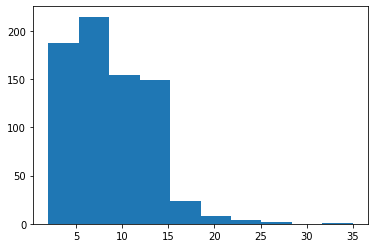

In [ ]:
x_len = []
for comment in comments:
    x_len.append(len(comment.split(' ')))
    if len(comment) > 100:
      print(len(comment))

plt.hist(x_len)
plt.show()

In [ ]:
def check_pos_neg(labels):
  positive = 0
  negative = 0
  for label in labels:
    if label == 1:
      positive = positive + 1
    else:
      negative = negative + 1
  return positive, negative

In [ ]:
check_pos_neg(labels)

(373, 373)

In [ ]:
max_seq = 60
embedding_size = 128

### **Word2Vec**

In [ ]:
input_gensim = []
for comment in comments:
    input_gensim.append(comment.split())

modelw2v = Word2Vec(input_gensim, size=embedding_size, window=5, min_count=0, workers=4, sg=1)
modelw2v.wv.save("./word.model")
model_embedding = word2vec.KeyedVectors.load('./word.model')

word_labels = []

for word in model_embedding.vocab.keys():
    word_labels.append(word)
    
def comment_embedding(comment, model_embedding, word_labels, max_seq, embedding_size):
    matrix = np.zeros((max_seq, embedding_size))
    words = comment.split()
    lencmt = len(words)

    for i in range(max_seq):
        indexword = i % lencmt
        if (max_seq - i < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = model_embedding[words[indexword]]
    matrix = np.array(matrix)
    return matrix

def comment_embedding2(comment, max_seq, embedding_size):
    matrix = np.zeros((max_seq, embedding_size))
    words = comment.split()
    lencmt = len(words)

    for i in range(max_seq):
        indexword = i % lencmt
        if (max_seq - i < lencmt):
            break
        if(words[indexword] in word_labels):
            matrix[i] = model_embedding[words[indexword]]
    matrix = np.array(matrix)
    return matrix

In [ ]:
train_data = []
label_data = []

for x in comments:
    train_data.append(comment_embedding(x, model_embedding, word_labels, max_seq, embedding_size))
train_data = np.array(train_data)

for y in labels:
    label_ = np.zeros(2)
    try:
        label_[int(y)] = 1
    except:
        label_[0] = 1
    label_data.append(label_)

In [ ]:
x_train = train_data.reshape(train_data.shape[0], max_seq, embedding_size, 1).astype('float32')
y_train = np.array(label_data)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)
print(check_pos_neg(np.argmax(y_train, axis=1)), x_train.shape)
print(check_pos_neg(np.argmax(y_val, axis=1)), x_val.shape)
print(check_pos_neg(np.argmax(y_test, axis=1)), x_test.shape)

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

filter_sizes = 2
dropout_rate = 0.5

model = keras.Sequential()
model.add(layers.Convolution2D(64, (filter_sizes, embedding_size),
                        padding='valid',
                        input_shape=(max_seq, embedding_size, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(max_seq - filter_sizes + 1, 1)))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [ ]:
numOfEpochs = 200
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=30, min_lr=0.0001, verbose = 1)
H = model.fit(x_train, y_train, 16, numOfEpochs, 1, [reduce_lr], validation_data=(x_val, y_val))

Epoch 1/200
28/28 [==============================] - 1s 14ms/step - loss: 0.6892 - accuracy: 0.5302 - val_loss: 0.6829 - val_accuracy: 0.5302 - lr: 0.0010
Epoch 2/200
28/28 [==============================] - 0s 8ms/step - loss: 0.6880 - accuracy: 0.5056 - val_loss: 0.6821 - val_accuracy: 0.5503 - lr: 0.0010
Epoch 3/200
28/28 [==============================] - 0s 8ms/step - loss: 0.6837 - accuracy: 0.5347 - val_loss: 0.6783 - val_accuracy: 0.5503 - lr: 0.0010
Epoch 4/200
28/28 [==============================] - 0s 8ms/step - loss: 0.6873 - accuracy: 0.5570 - val_loss: 0.6778 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 5/200
28/28 [==============================] - 0s 9ms/step - loss: 0.6849 - accuracy: 0.5324 - val_loss: 0.6809 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 6/200
28/28 [==============================] - 0s 9ms/step - loss: 0.6822 - accuracy: 0.5749 - val_loss: 0.6807 - val_accuracy: 0.6107 - lr: 0.0010
Epoch 7/200
28/28 [==============================] - 0s 9ms/step - loss: 0.

In [ ]:
model.evaluate(x_test, y_test, verbose=0)

[0.6003931164741516, 0.6600000262260437]

In [ ]:
model_saved = load_model('./model2.h5')
# model_saved.load_weights('./model_w.h5')
# model_saved.evaluate(x_test, y_test, verbose=0)
model_saved.summary()

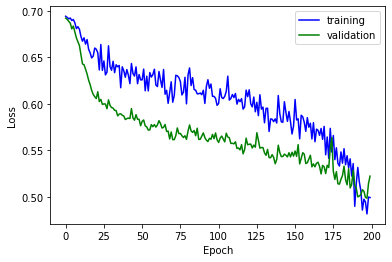

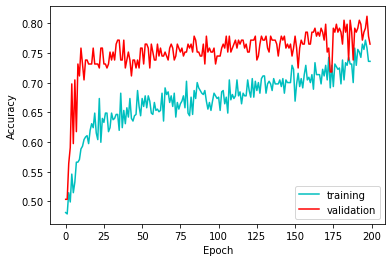

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(0, numOfEpochs), H.history['loss'], 'b', label='training')
plt.plot(np.arange(0, numOfEpochs), H.history['val_loss'], 'g', label='validation')
# plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./Model/Loss(75).png')
plt.show()

fig = plt.figure()
plt.plot(np.arange(0, numOfEpochs), H.history['accuracy'], 'c', label='training')
plt.plot(np.arange(0, numOfEpochs), H.history['val_accuracy'], 'r', label='validation')
# plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('./Model/Accuracy(75).png')
plt.show()

Precision: 0.747093
Recall: 0.742857
F1 score: 0.743751
[[64 16]
 [22 48]]


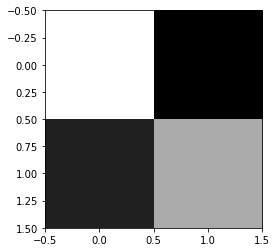

In [ ]:
from sklearn.metrics import *

yhat_classes = model.predict(x_test, verbose=0)
yhat_classes = np.argmax(yhat_classes, axis = 1)
y_test_ = np.argmax(y_test, axis=1)
# predict crisp classes for test set
precision = precision_score(y_test_, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_, yhat_classes, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_, yhat_classes, average='macro')
print('F1 score: %f' % f1)
plt.imshow(confusion_matrix(y_test_, yhat_classes), 'gray')
print(confusion_matrix(y_test_, yhat_classes))

In [ ]:
model.save('./Model/model(75).h5')
model.save_weights('./Model/model_w(75).h5')

In [ ]:
yLabels = ['Tiêu cực', 'Tích cực']

In [ ]:
def test(comment_test, model, max_seq = 200, embedding_size = 128):
  gensim_test = []
  gensim_test.append(comment_test.split())

  modelWord2Vec = Word2Vec(gensim_test, size=embedding_size, window=5, min_count=0, workers=4, sg=1)
  modelWord2Vec.wv.save("./word_test.model")
  model_embedding_ = word2vec.KeyedVectors.load('./word_test.model')

  word_test = []

  for word in model_embedding_.vocab.keys():
      word_test.append(word)

  # test_embed = comment_embedding(comment_test, model_embedding_, word_test, max_seq, embedding_size)
  test_embed = comment_embedding2(comment_test, max_seq, embedding_size)
  test_embed = test_embed.reshape(1, max_seq, embedding_size, 1)

  yLabels = ['Tiêu cực', 'Tích cực']
  return yLabels[np.argmax(model.predict(test_embed))]

In [ ]:
model_saved = load_model('./model2.h5')
model_saved.load_weights('./model2_w.h5')
print(model_saved.evaluate(x_test, y_test, verbose=0))
print(model_saved.evaluate(x_train, y_train, verbose=0))
print(model_saved.evaluate(x_val, y_val, verbose=0))
# model_saved.summary()

[0.5274800658226013, 0.746666669845581]
[0.554490864276886, 0.7404921650886536]
[0.5321246981620789, 0.7516778707504272]


In [ ]:
for x in comments_neg:
  print(x)
  print(test(x, model_saved, 60, 128))
  print('-------------------')

In [ ]:
x_test.shape

In [ ]:
test('bọn gà', model_saved)

'Tiêu cực'

In [ ]:
test('bọn gà')

'Tiêu cực'

In [ ]:
comments_neg

### **Embedding**

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
file = open('./data.json',)
data = json.load(file)

comments = []
labels = []
comments_pos = []
labels_pos = []
comments_neg = []
labels_neg = []
for item in data:
    if item['Navigation'] == 0:
      comments_neg.append(item['Content'])
      labels_neg.append(item['Navigation'])
    else:
      comments_pos.append(item['Content'])
      labels_pos.append(item['Navigation'])

comments.extend(comments_neg)
labels.extend(labels_neg)
n = 0
comments.extend(comments_pos[len(comments_neg)*n:len(comments_neg)*(n+1)])
labels.extend(labels_pos[len(comments_neg)*n:len(comments_neg)*(n+1)])


In [ ]:
check_pos_neg(labels)

(373, 373)

In [ ]:
vocab_size = 80
max_length = 128

In [ ]:
tokennizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokennizer.fit_on_texts(comments) 

sequece_docs = tokennizer.texts_to_sequences(comments)
padded_docs = pad_sequences(sequece_docs, maxlen=max_length,
                                padding='post', truncating='post')

In [ ]:
tokennizer.word_index

In [ ]:
padded_docs[0]

(64,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(padded_docs, labels, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.25)
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(447, 128) (447,)
(149, 128) (149,)
(150, 128) (150,)


In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(447, 64) (447,)
(149, 64) (149,)
(150, 64) (150,)


In [ ]:
testSetAccuracyArray = []
for i in range(2, 13):
  model = Sequential()
  model.add(Embedding(vocab_size, i, input_length=max_length))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  numOfEpochs = 100
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=30, min_lr=0.0001, verbose = 1)
  H = model.fit(x_train, y_train, 16, numOfEpochs, 1, [reduce_lr], validation_data=(x_val, y_val))
  testSetAccuracyArray.append(model.evaluate(x_test, y_test, verbose=0)[1])


Epoch 1/100
28/28 [==============================] - 1s 9ms/step - loss: 0.6941 - accuracy: 0.4944 - val_loss: 0.6934 - val_accuracy: 0.4899 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6932 - accuracy: 0.5257 - val_loss: 0.6931 - val_accuracy: 0.5235 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.4966 - val_loss: 0.6930 - val_accuracy: 0.4899 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5347 - val_loss: 0.6928 - val_accuracy: 0.4899 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4877 - val_loss: 0.6925 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.5660 - val_loss: 0.6917 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 7/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6

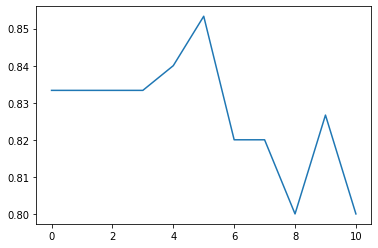

In [ ]:
plt.plot(testSetAccuracyArray)
plt.show()

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=max_length))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


In [ ]:
testSetAccuracyArray

In [ ]:
numOfEpochs = 100
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=30, min_lr=0.0001, verbose = 1)
H = model.fit(x_train, y_train, 16, numOfEpochs, 1, [reduce_lr], validation_data=(x_val, y_val))

Epoch 1/100
28/28 [==============================] - 2s 18ms/step - loss: 0.6954 - accuracy: 0.4832 - val_loss: 0.6936 - val_accuracy: 0.5101 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6916 - accuracy: 0.5123 - val_loss: 0.6930 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 0.6914 - accuracy: 0.5145 - val_loss: 0.6918 - val_accuracy: 0.5906 - lr: 0.0010
Epoch 4/100
28/28 [==============================] - 0s 8ms/step - loss: 0.6916 - accuracy: 0.5280 - val_loss: 0.6910 - val_accuracy: 0.5302 - lr: 0.0010
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6876 - accuracy: 0.5682 - val_loss: 0.6894 - val_accuracy: 0.6443 - lr: 0.0010
Epoch 6/100
28/28 [==============================] - 0s 7ms/step - loss: 0.6856 - accuracy: 0.5749 - val_loss: 0.6874 - val_accuracy: 0.6711 - lr: 0.0010
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 0.

In [ ]:
model.evaluate(x_test, y_test, verbose=0)

[0.4048866927623749, 0.846666693687439]

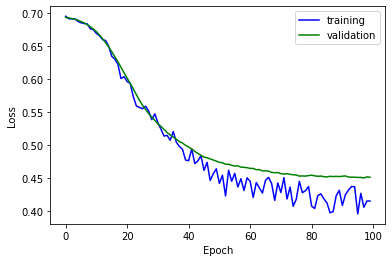

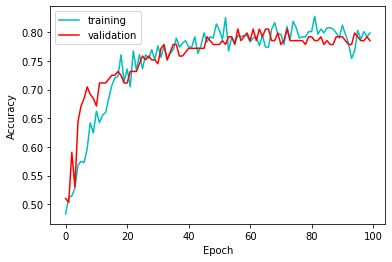

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(0, numOfEpochs), H.history['loss'], 'b', label='training')
plt.plot(np.arange(0, numOfEpochs), H.history['val_loss'], 'g', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./Model_Embedding/Loss(82)_2.png')
plt.show()

fig = plt.figure()
plt.plot(np.arange(0, numOfEpochs), H.history['accuracy'], 'c', label='training')
plt.plot(np.arange(0, numOfEpochs), H.history['val_accuracy'], 'r', label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('./Model_Embedding/Accuracy(82)_2.png')
plt.show()

Precision: 0.851732
Recall: 0.846667
F1 score: 0.846113
[[68  7]
 [16 59]]


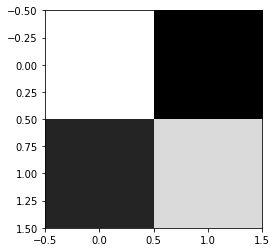

In [ ]:
from sklearn.metrics import *
from sklearn.metrics import classification_report
yhat_classes = model.predict(x_test, verbose=0)
y_test_ = np.asarray(y_test)
y_hat = []
for y in yhat_classes:
  if y*100 > 50:
    y_hat.append(1)
  else:
    y_hat.append(0)
precision = precision_score(y_test_, y_hat, average='macro')
print('Precision: %f' % precision)
recall = recall_score(y_test_, y_hat, average='macro')
print('Recall: %f' % recall)
f1 = f1_score(y_test_, y_hat, average='macro')
print('F1 score: %f' % f1)
plt.imshow(confusion_matrix(y_test_, y_hat), 'gray')
print(confusion_matrix(y_test_, y_hat))

In [ ]:
model.save('./Model_Embedding/model(85).h5')
model.save_weights('./Model_Embedding/model_w(85).h5')

In [ ]:
yLabels = ['Tiêu cực', 'Tích cực']
def predict_input(x_input, model, tokennizer):
  test_input = [x_input]
  sequece_docs_ = tokennizer.texts_to_sequences(test_input)
  padded_docs_ = pad_sequences(sequece_docs_, maxlen=max_length,
                                  padding='post', truncating='post')
  if model.predict(padded_docs_)[0]*100 < 50:
    return 'Tiêu cực'
  else:
    return 'Tích cực'

In [ ]:
model_saved = load_model('./Model_Embedding/model(80).h5')
model_saved.load_weights('./Model_Embedding/model_w(80).h5')

In [ ]:
print(predict_input('sao mày ngu quá vậy, cứ cãi tao vậy', model, tokennizer))
print(predict_input('thằng kia lừa đảo thế thì chơi chó thật, nó lừa cả xóm chỗ tôi này', model, tokennizer))
print(predict_input('Đồ lừa đảo', model, tokennizer))

Tiêu cực
Tiêu cực
Tiêu cực


In [ ]:
print(predict_input('Cảm ơn thầy và các bạn', model, tokennizer))
print(predict_input('Em chào thầy', model, tokennizer))
print(predict_input('Ai cũng thân thiện và dễ thương', model, tokennizer))

Tích cực
Tích cực
Tích cực


In [ ]:
print(predict_input('cảm ơn', model, tokennizer))

Tích cực


In [ ]:
print(predict_input('chào thầy', model, tokennizer))

Tiêu cực


In [ ]:
for s in comments_neg:
  print(s)
  print(predict_input(s, model, tokennizer))
  print('------------')

văn 8 5 còn ít mà mình thì còn đéo được 6 5
Tích cực
------------
Vãi bảy phẩy mấy mà ít cấp 3 e chưa từng trên 6 phẩy
Tiêu cực
------------
Công nhận Pew giống JVevermind vãi
Tiêu cực
------------
Ông pew nói chuyện nge thấm vãi chưởng
Tiêu cực
------------
Oh yeah nghe phê vãi chưởng
Tiêu cực
------------
nghe mỗi cái giọng a pew đã thích cmnr
Tích cực
------------
nghe ổng nói tự ái vl
Tiêu cực
------------
a giống e vãi cc e cx đang học trong lớp quái vật 3
Tiêu cực
------------
Anh pew hài vãi
Tích cực
------------
Pew học giỏi vãi
Tích cực
------------
học giỏi ghê em đc 5 điểm là mừng lắm rồi vl
Tích cực
------------
ông này thấy chém như thế mà dốt văn thì thôi
Tiêu cực
------------
đm nghe ổng nói mà buồn dễ sợ luôn Nói phét
Tích cực
------------
Ông đùa tôi à điểm phẩy bằng bọn học sinh giỏi cmnr
Tích cực
------------
cô dạy văn anh giống cô dạy văn em vc
Tích cực
------------
Má anh khiêm tốn VL
Tiêu cực
------------
anh pew làm bài giỏi vãi
Tích cực
------------
Cuồng anh đ

In [ ]:
model_saved.summary()